# Prior estimation

In [1]:
#include("../src/ObjectiveEmpiricalBayes.jl")
using Revise
using ObjectiveEmpiricalBayes
import ObjectiveEmpiricalBayes: OptConfig, Transformation, FEModel, generatedata, transformmodel, 
    ReferenceRegularizer, ThikonovRegularizer, cvscore, ebprior, compareplot

using Random: seed!
linspace(x...) = LinRange(x...) |> collect

OPTCONFIG=OptConfig(XTOLABS=1e-8, DEBUG=true);


┌ Info: Recompiling stale cache file /Users/alex/.julia/compiled/v1.0/ObjectiveEmpiricalBayes/DvnQ2.ji for ObjectiveEmpiricalBayes [c9f68547-bb38-4662-99af-2e1b295e5967]
└ @ Base loading.jl:1187


In [3]:
using PyCall, PyPlot
# enable pyplot-latex
PyCall.PyDict(PyPlot.matplotlib["rcParams"])["text.usetex"] = true

true

## The Model

In [4]:
using Distributions

# exponential
xlims = (0,4)
n = 200 # was 500
ndata = 100
σ = 0.3
prior = Truncated(MixtureModel([Normal(mu, .5) for mu in [1, 3]]), xlims...)


t    = Transformation(x->exp(x), x->log(x))

Transformation(getfield(Main, Symbol("##5#7"))(), getfield(Main, Symbol("##6#8"))())

In [5]:
randseed=90
seed!(randseed)
#srand(2)
m = FEModel(f=x->x, xs=linspace(xlims...,n), σ=σ)
d = generatedata(m, prior, ndata);
mt   = transformmodel(m, t)

FEModel(getfield(ObjectiveEmpiricalBayes, Symbol("#ft#68")){FEModel,Transformation}(FEModel(getfield(Main, Symbol("##9#10"))(), [0.0, 0.0201005, 0.040201, 0.0603015, 0.080402, 0.100503, 0.120603, 0.140704, 0.160804, 0.180905  …  3.8191, 3.8392, 3.8593, 3.8794, 3.8995, 3.9196, 3.9397, 3.9598, 3.9799, 4.0], 0.3), Transformation(getfield(Main, Symbol("##5#7"))(), getfield(Main, Symbol("##6#8"))())), range(1.0, stop=54.598150033144236, length=200), 0.3)

In [6]:
ncv = 20
kfold = length(d);

In [7]:
lims = ([0,4],[0,.6],[1,55], [0,.2])

([0, 4], [0.0, 0.6], [1, 55], [0.0, 0.2])

## Results

In [26]:
figsize=(4*0.8,3*0.8)

(3.2, 2.4000000000000004)

 93.532358 seconds (137.09 M allocations: 158.143 GiB, 16.79% gc time)
regR = (regs[argmax(ss)]).γ = 

0.19473684210526315


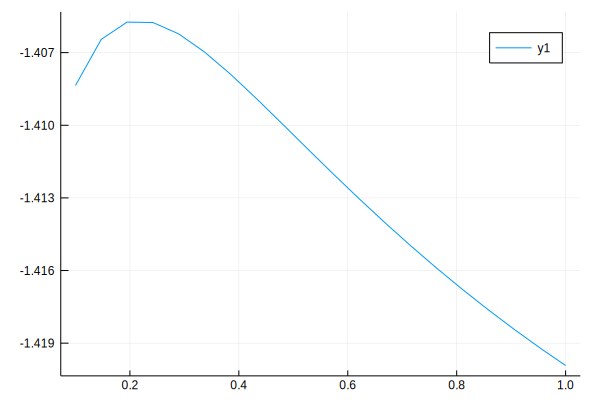

In [9]:
using Plots
## er estimator
regs = [ReferenceRegularizer(m, γ) for γ in linspace(0.1,1,ncv)]
@time ss = [cvscore(m, d, d->ebprior(m, d, r, OPTCONFIG), kfold) for r in regs]

@show regR = regs[argmax(ss)].γ
Plots.plot([r.γ for r in regs], ss)

130.171865 seconds (133.88 M allocations: 207.723 GiB, 20.30% gc time)
regRt = (regs[argmax(ss)]).γ = 0.19473684210526315


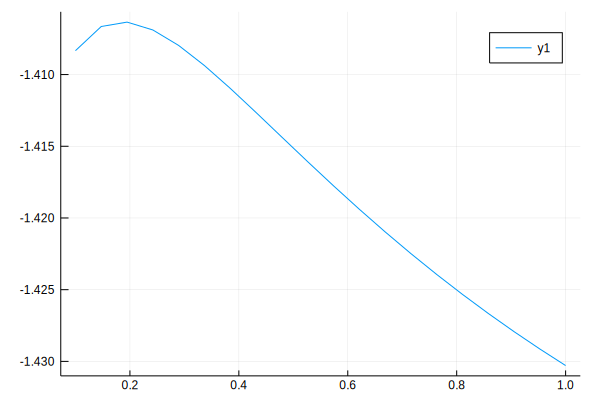

In [10]:
## er estimator transformed
regs = [ReferenceRegularizer(mt, γ) for γ in linspace(0.1,1,ncv)]
@time ss = [cvscore(mt, d, d->ebprior(mt, d, r, OPTCONFIG), kfold) for r in regs]

@show regRt = regs[argmax(ss)].γ
Plots.plot([r.γ for r in regs], ss)

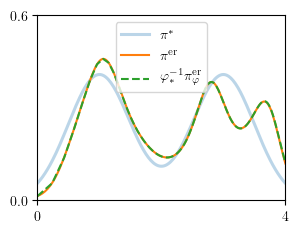

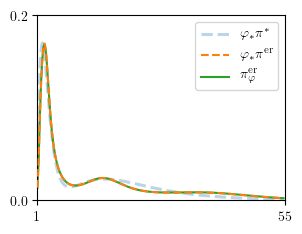

(Figure(PyObject <Figure size 320x240 with 1 Axes>), Figure(PyObject <Figure size 320x240 with 1 Axes>))

In [27]:
wR  = ebprior(m,  d, ReferenceRegularizer(m,  regR), OPTCONFIG)
wRt = ebprior(mt, d, ReferenceRegularizer(mt, regRt), OPTCONFIG)

p1, p2 = compareplot(m, t, pdf.(prior, m.xs), wR, wRt, "er", lims...; figsize=figsize, savename="eb$randseed")

#plt2mat(p1, "er.mat")
#plt2mat(p2, "erT.mat")

187.070527 seconds (136.64 M allocations: 324.190 GiB, 21.07% gc time)


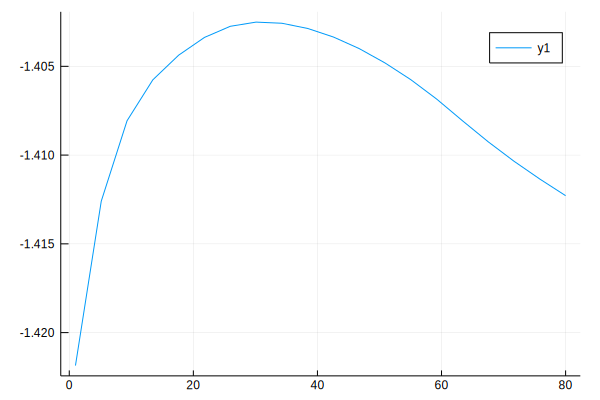

In [12]:
## thik estimator
regs = [ThikonovRegularizer(γ) for γ in linspace(1,80,ncv)]
@time ss = [cvscore(m, d, d->ebprior(m, d, r, OPTCONFIG), kfold) for r in regs]
regT = regs[argmax(ss)].γ
Plots.plot([r.γ for r in regs], ss)


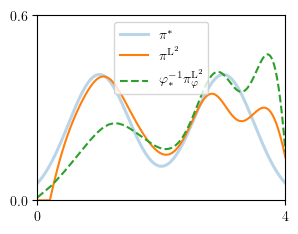

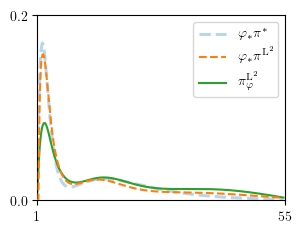

(Figure(PyObject <Figure size 320x240 with 1 Axes>), Figure(PyObject <Figure size 320x240 with 1 Axes>))

In [28]:
wT = ebprior(m,  d, ThikonovRegularizer(regT), OPTCONFIG)
wTto = ebprior(mt, d, ThikonovRegularizer(regT), OPTCONFIG)

p1,p2 = compareplot(m, t, pdf.(prior, m.xs), wT, wTto, "L^2", lims...; figsize=figsize, savename="l2gammafix$randseed")

#plt2mat(p1, "l2.mat")
#plt2mat(p2, "l2T.mat")

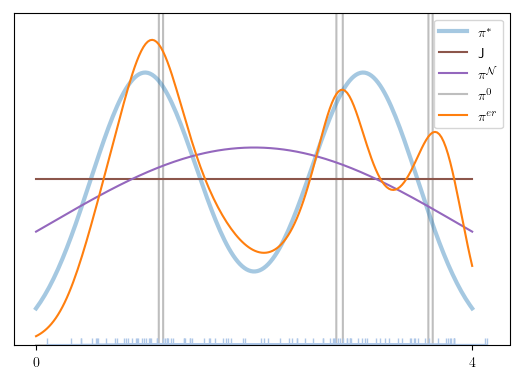

In [40]:
using LinearAlgebra

w0 = ebprior(m, d, ThikonovRegularizer(0), OptConfig(XTOLABS=1e-30, DEBUG=false);)
w0 = normalize!([(w>0.05) ? 0.001 : 0 for w in w0], 1)
wu = normalize!(ones(length(w0)), 1)

wp = normalize!(pdf.(prior, m.xs), 1)
wn = normalize!(pdf.(Distributions.Normal(2,1.9
            ), m.xs), 1)



w2dens(x) = ObjectiveEmpiricalBayes.weighttodensity(m.xs, x)
scaling = 0.8
PyPlot.figure(figsize=(8*scaling,5.4*scaling))
PyPlot.plot(m.xs, wp|>w2dens, label="\$\\pi^*\$", alpha=.4, linewidth=3)
PyPlot.plot(m.xs,  wu |> w2dens, label = "J", color="#8c564b")
PyPlot.plot(m.xs, wn|> w2dens, label="\$\\pi^\\mathcal{N}\$", color="#9467bd")
PyPlot.plot(m.xs, w0|> w2dens, label="\$\\pi^0\$", zorder=-100, alpha=.5, color="#7f7f7f")
PyPlot.plot(m.xs, wR|> w2dens, label="\$\\pi^{er}\$")
PyPlot.legend()


PyPlot.plot(d, zero(d), marker="2", markersize=10, color="#aec7e8")
PyPlot.ylim(0,0.5)
PyPlot.xticks([0,4])
PyPlot.yticks([])
PyPlot.savefig("all.pdf", bbox_inches="tight")

135.510475 seconds (133.54 M allocations: 231.227 GiB, 21.21% gc time)


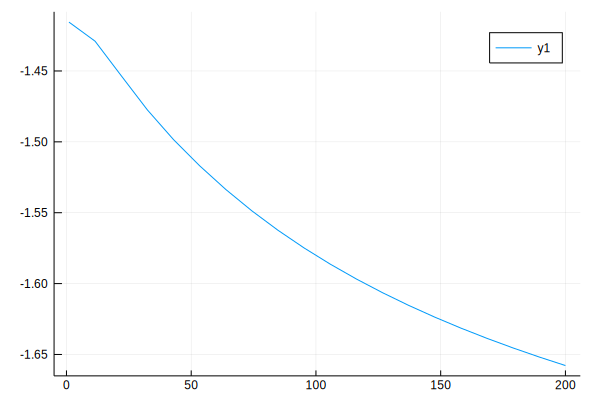

In [13]:
## thik estimator transformed
regs = [ThikonovRegularizer(γ) for γ in linspace(1,200,ncv)]
@time ss = [cvscore(mt, d, d->ebprior(mt, d, r, OPTCONFIG), kfold) for r in regs]
regTt = regs[argmax(ss)].γ
Plots.plot([r.γ for r in regs], ss)


In [ ]:
wT = ebprior(m,  d, ThikonovRegularizer(regT), OPTCONFIG)
wTt = ebprior(mt, d, ThikonovRegularizer(regTt), OPTCONFIG)

p1, p2 = compareplot(m, t, pdf.(prior, m.xs), wT, wTt, "L^2", lims...; figsize=figsize, savename="l2$randseed")

In [16]:
using MAT
function plt2mat(p, filename)
    d = [(filter(isalpha, l[:get_label]()), hcat(l[:get_data]()...)) for a in p[:axes] for l in a[:lines] ] |> Dict
    matwrite(filename, d)
end

ArgumentError: ArgumentError: Package MAT not found in current path:
- Run `import Pkg; Pkg.add("MAT")` to install the MAT package.
